# Using rewards
In order to compute more complex moments such as higher order (cross)-moments that are not directly made available as cached properties of {class}`~phasegen.distributions.PhaseTypeDistribution`, we can specify our own rewards. A {class}`~phasegen.rewards.Reward` is a means of *rewarding* or weighting each state so as to obtain the moments of the quantity of interest. Examples of common rewards are {class}`~phasegen.rewards.TreeHeightReward` and {class}`~phasegen.rewards.TotalBranchLengthReward` or {class}`~phasegen.rewards.UnfoldedSFSReward`. We can use {class}`~phasegen.distributions.PhaseTypeDistribution`'s {meth}`~phasegen.distributions.PhaseTypeDistribution.moment`, which requires a *tuple* of rewards to be specified, whose length equals the order of the moment to be computed.

In [1]:
devtools::install_github("Sendrowski/PhaseGen")

library(phasegen)

setwd("~/PycharmProjects/PhaseGen/")

options(
  repr.plot.width = 7,
  repr.plot.height = 5
)

Using GitHub PAT from the git credential store.

Skipping install of 'phasegen' from a github remote, the SHA1 (718d8dab) has not changed since last install.
  Use `force = TRUE` to force installation



In [2]:
library(phasegen)

pg <- load_phasegen()

Warning message in poetry_config(required_module):
“This project appears to use Poetry for Python dependency management.
However, the 'poetry' command line tool is not available.
reticulate will be unable to activate this project.
Please ensure that 'poetry' is available on the PATH.”


In [3]:
coal <- pg$Coalescent(n = 10)

We can explicitly compute the moments made available as cached properties. Note that {meth}`~phasegen.distributions.PhaseTypeDistribution.moment` provides centered moments by default.

In [4]:
# mean tree height
coal$tree_height$mean == coal$moment(1, c(pg$TreeHeightReward()))

[1] TRUE

In [5]:
# variance of tree height
coal$moment(2, c(pg$TreeHeightReward(), pg$TreeHeightReward())) == coal$tree_height$var

[1] TRUE

In [6]:
# second non-central moment of total branch length
coal$total_branch_length$m2 == coal$moment(2, c(pg$TotalBranchLengthReward(), pg$TotalBranchLengthReward()), center = FALSE)

[1] TRUE

In [7]:
# mean of the 2nd unfolded SFS entry
coal$sfs$mean$data[[3]] == coal$moment(1, c(pg$UnfoldedSFSReward(2)))

[1] TRUE

If necessary, we can also compute much higher order (cross)-moments.

In [8]:
# 5th non-central moment of tree height
coal$moment(5, lapply(1:5, function(x) pg$TreeHeightReward()))

[1] 48.26442

In [9]:
# 3rd non-central moment of 2nd, 3rd and 4th unfolded SFS entries
coal$moment(3, c(pg$UnfoldedSFSReward(2), pg$UnfoldedSFSReward(3), pg$UnfoldedSFSReward(4)))

[1] 0.005538771

## Combining rewards
Sometimes we may want to combine multiple rewards. To this end, we can use {class}`~phasegen.rewards.ProductReward` or {class}`~phasegen.rewards.SumReward`. Let us for example compute the mean SFS over the first 2 out of 3 demes.

In [10]:
# 3-deme coalescent with symmetric migration
coal <- pg$Coalescent(
    n = list(pop_0 = 3, pop_1 = 2, pop_2 = 0),
    demography = pg$Demography(
        pop_sizes = list(pop_0 = 3, pop_1 = 0.5, pop_2 = 0.1),
        events = c(
            pg$SymmetricMigrationRateChanges(
                pops = c('pop_0', 'pop_1', 'pop_2'),
                rate = 1
            )
        )
    )
)

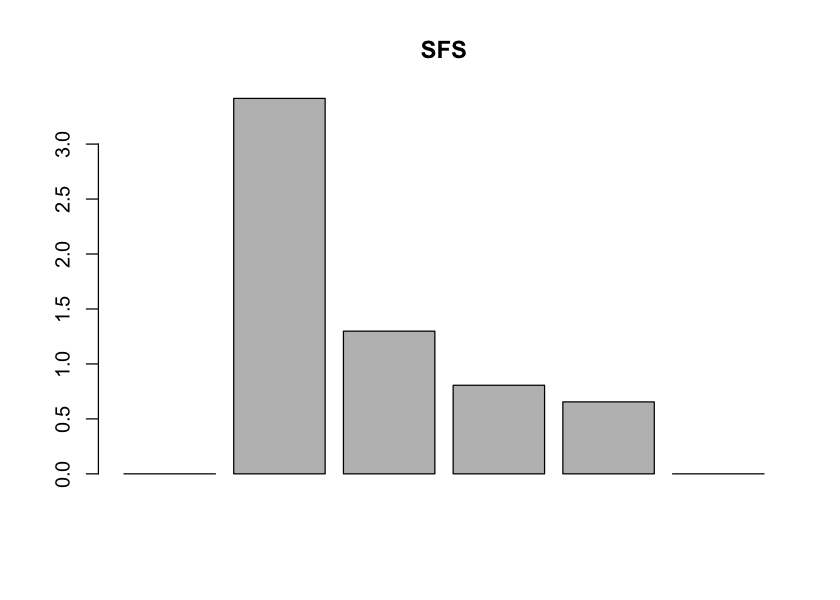

In [11]:
sfs <- coal$sfs$moment(1, c(pg$SumReward(c(pg$DemeReward('pop_0'), pg$DemeReward('pop_1')))))

barplot(sfs$data, main = 'SFS')

Note that we have here used {meth}`~phasegen.distributions.UnfoldedSFSDistribution.moment` of {class}`~phasegen.distributions.UnfoldedSFSDistribution`. This method internally uses a {class}`~phasegen.rewards.ProductReward` to combine the given reward with {class}`~phasegen.rewards.UnfoldedSFSReward` to obtain the SFS for all possible SFS bins. Had we used {meth}`~phasegen.distributions.Coalescent.moment` instead, we would have needed to specify the reward for each SFS bin separately.

In [12]:
demes <- pg$SumReward(c(pg$DemeReward('pop_0'), pg$DemeReward('pop_1')))
sfs_bin <- pg$UnfoldedSFSReward(2)

# take product of SFS reward for second SFS bin with sum of rewards for first two demes
sfs$data[[3]] == coal$moment(1, c(pg$ProductReward(c(demes, sfs_bin))))

[1] TRUE

## Tracing reward accumulation over time
Since rewards are accumulated over time, we can trace their accumulation over time. This can be useful for debugging purposes or to understand how the reward is accrued over time. To this end, we can use {class}`~phasegen.distributions.PhaseTypeDistribution`'s {meth}`~phasegen.distributions.PhaseTypeDistribution.accumulate` and {meth}`~phasegen.distributions.PhaseTypeDistribution.plot_accumulation`. Note that this is different from the CDF, which instead accumulates probability mass over time.

In [13]:
# accumulation of mean SFS over all demes
coal$sfs$accumulate(k = 1, end_times = 0:8)

0,0.00000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000
0,2.71071621,3.5215679,3.8661238,4.0388454,4.1317097,4.1830456,4.2117258,4.2278121
0,0.63824486,1.1380923,1.4015464,1.5445715,1.6238582,1.6681967,1.6930741,1.7070495
0,0.20713969,0.5569246,0.7892993,0.9259031,1.0038627,1.0479269,1.0727475,1.0867113
0,0.07277186,0.3307095,0.5608889,0.7099682,0.7979459,0.8482717,0.8767432,0.8927864
0,0.00000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000


## Adjusting start and end times of reward accumulation
By default, rewards are accumulated from time 0 until time of almost sure absorption. We can adjust the start and end times of reward accumulation by specifying the `start_time` and `end_time` arguments to
{class}`~phasegen.distributions.Coalescent` or {class}`~phasegen.distributions.PhaseTypeDistribution`'s {meth}`~phasegen.distributions.PhaseTypeDistribution.moment`.

In [14]:
mean1 <- pg$Coalescent(n = 10, end_time = 2)$tree_height$mean
mean2 <- pg$Coalescent(n = 10)$tree_height$moment(1, end_time = 2)

mean1 == mean2

[1] TRUE